In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import pybedtools as bt

from collections import Counter, deque
import pickle
import re
import os

from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
import matplotlib.collections as mcol
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from matplotlib_venn import venn3, venn2


from matplotlib import gridspec
from scipy.stats import shapiro, mannwhitneyu, iqr,spearmanr, ttest_rel, ttest_ind

import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

from adjustText import adjust_text

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-7:-2]
color3=mcp.gen_color(cmap="Blues",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]



def flatten(l):
    return [item for sublist in l for item in sublist]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

        
def change_height(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)


def get_aster(p):
    if p <= 0.0001:
        aster= "****"
    elif p <= 0.001:
        aster= "***"
    elif p <= 0.01:
        aster= "**"
    elif p <= 0.05:
        aster= "*"
    else:
        aster= 'ns'
    return aster


colorPalette = {
    "ANDR"    : color1[-1],
    "High"    : color2[-1],
    "Mid-high": color2[-1],
    "Mid-low" : color2[-1],
    "low"     : color2[-1],
    
    "ARcre"   : "#F19323",
    "cre"     : "#888888",
}

MAPty = pickle.load(open('data/MAPty.p', 'rb'))
MAPcl = pickle.load(open('data/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('data/MAPgn.p', 'rb'))

BEDPRO = pickle.load(open('../data/pickle/BEDPRO.p', 'rb'))
GENES = dict(zip(BEDPRO['Gene'], BEDPRO['Name']))

# N contains BW signal for RNA seq but BEDPRO contains  
N = pd.read_table('../data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_Vh'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['Vh'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_30m'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['30m'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_4h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['4h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_16h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['16h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_72h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['72h'])))

T = pd.read_table('../data/TABLE/TF.tmm.tsv').set_index('Name').drop_duplicates()
T = pd.read_table('../data/TABLE/TF.CA.tmm.tsv').set_index('Name').drop_duplicates()

H = pickle.load(open('../data/G/G_ALL.p', 'rb'))


    
BEDPES_H3K27ac = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K27ac[h] = bt.BedTool(f"../data/BEDPE/ALL_H3K27ac_{h}.tmm.bedpe")

BEDPES_H3K4me3 = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K4me3[h] = bt.BedTool(f"../data/BEDPE/ALL_H3K4me3_{h}.tmm.bedpe")
    
    
sns.set(font_scale=2, style='ticks')

In [2]:
BEDPRO['LFC_16h'] = np.log2((BEDPRO['16h']+1) / (BEDPRO['Vh']+1) )
tmp = BEDPRO.sort_values('LFC_16h')
up = tmp.loc[tmp['LFC_16h'] > 1, 'Name'].tolist()
down = tmp.loc[tmp['LFC_16h'] < -1, 'Name'].tolist()


Counter(tmp.loc[tmp['LFC_16h'] > 1, 'Quartile']), Counter(tmp.loc[tmp['LFC_16h'] < -1, 'Quartile'])

(Counter({'Mid-low': 25, 'ANDR': 8, 'High': 4, 'low': 15, 'Mid-high': 6}),
 Counter({'low': 7, 'Mid-high': 9, 'Mid-low': 16, 'High': 4}))

Text(0.5, 0, '')

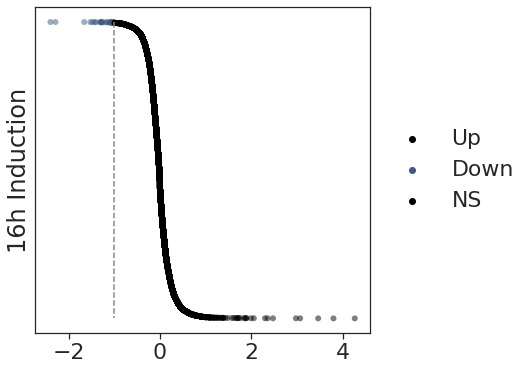

In [3]:
tmp['DE'] = 'NS'
tmp.loc[tmp['LFC_16h'] > 1, 'DE'] = 'Up'
tmp.loc[tmp['LFC_16h'] < -1, 'DE'] = 'Down'

fig = plt.figure(figsize=[6,6])
sns.scatterplot(data=tmp, y='Gene', x='LFC_16h', hue='DE', palette=['#000000', '#3d5a80', '#000000'], hue_order=['Up', 'Down', 'NS'], linewidth=0,alpha=0.5)
plt.yticks([])

#plt.plot([-2,len(tmp)+2], [1,1], ls='--', c='#888888')
plt.plot([-1,-1],[-2,len(tmp)+2], ls='--', c='#888888')

sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)

plt.ylabel('16h Induction')
plt.xlabel('')


#fig.savefig('../plots/induction_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )


Text(0.5, 0, '')

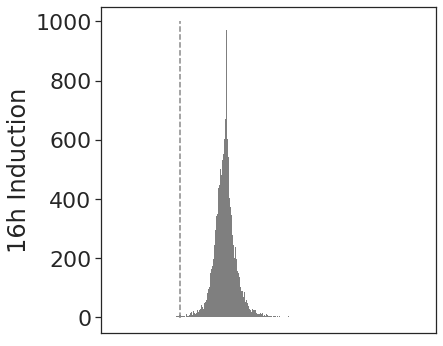

In [54]:
tmp['DE'] = 'NS'
tmp.loc[tmp['LFC_16h'] > 1, 'DE'] = 'Up'
tmp.loc[tmp['LFC_16h'] < -1, 'DE'] = 'Down'

plt.figure(figsize=[6,6])
sns.histplot(data=tmp, x='LFC_16h', color='#000000', linewidth=0,alpha=0.5)
plt.xticks([])

#plt.plot([-2,len(tmp)+2], [1,1], ls='--', c='#888888')
plt.plot([-1,-1],[-2,1000], ls='--', c='#888888')

#sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)

plt.ylabel('16h Induction')
plt.xlabel('')




Text(0.5, 1.0, 'Down Genes')

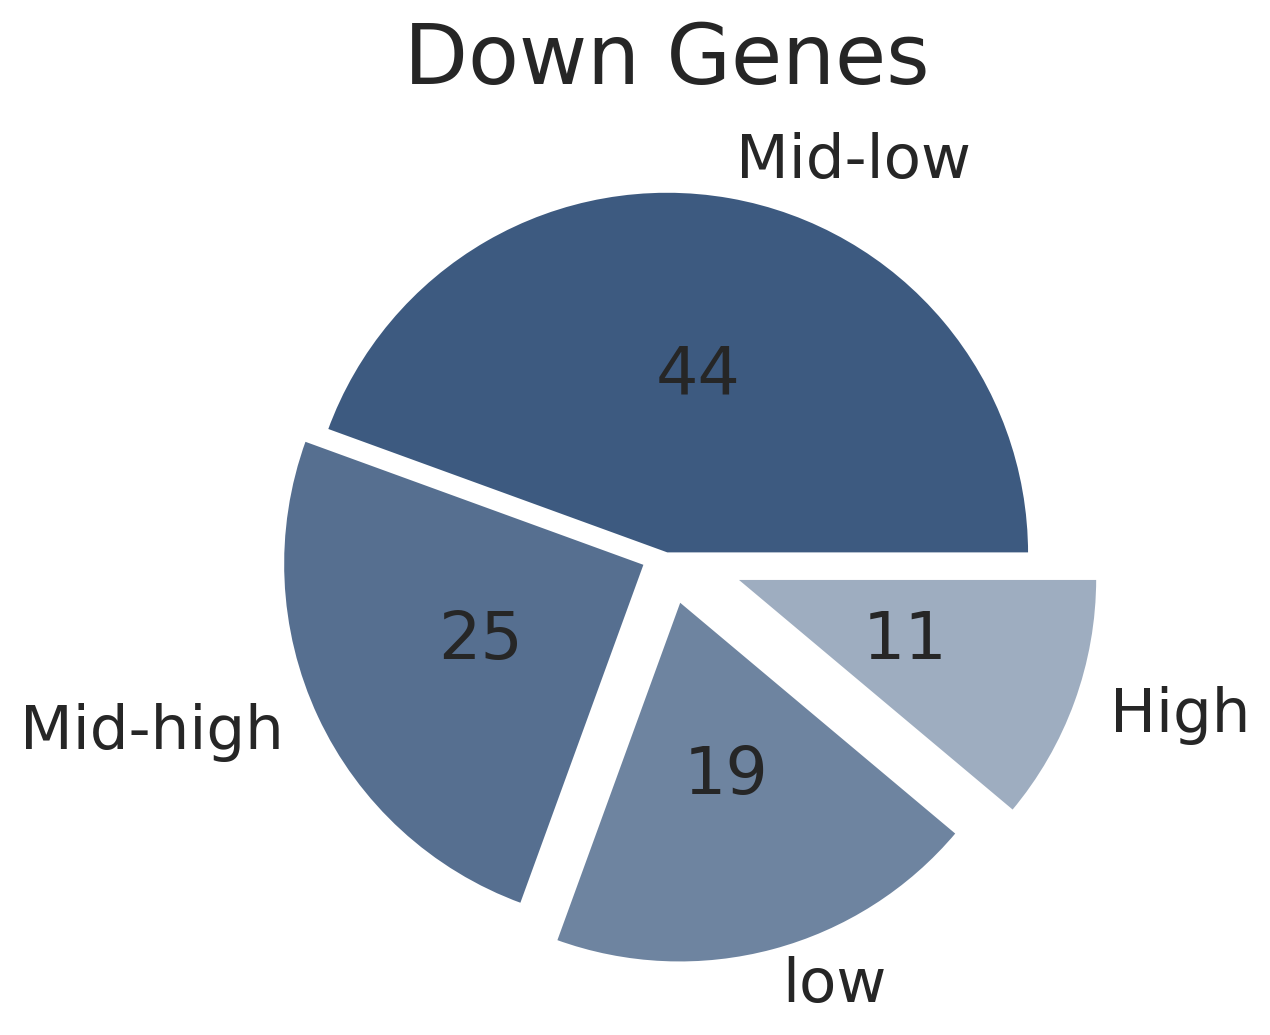

In [4]:
data = tmp[tmp['DE'] == 'Down'].groupby('Quartile').size().reset_index().sort_values(0,ascending=False)


#data = BEDANDR.groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

fig = plt.figure(figsize=[6,6], dpi=200)
patches, texts, autotexts = plt.pie(
    x=data[0], 
    autopct="%.f", 
    explode=np.linspace(0,0.2, data.shape[0]),
    labels=data["Quartile"], 
    pctdistance=0.5, 
    colors=[   '#3D5A80', '#566F90', '#6E84A0','#9EADC0'])
plt.title('Down Genes', fontsize=30)




#fig.savefig('../plots/pie_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )


# Contact Change in AR-bound Enhancers

In [5]:

s = 'H3K27ac'

#geneset = list([n for n, nc in MAPcl.items() if nc == 'ANDR'])
geneset = up
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}
print(f'uANDR G: {len(I)}')
A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'ARcre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]
print(f'uANDR G -> ARcre: {len(A)}')
c1 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

#geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'ANDR'], size=len(andr)))
geneset = down
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}
print(f'dANDR G: {len(I)}')
A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'ARcre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]

print(f'dANDR G -> ARcre: {len(A)}')
c2 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=100))
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}
print(f'HIGH G: {len(I)}')
A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'cre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]
print(f'HIGH G -> cre: {len(A)}')
c3 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])


BOOT = 100
FC1_H3K27ac = np.zeros((BOOT, 5))
FC2_H3K27ac = np.zeros((BOOT, 5))
FC3_H3K27ac = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=100))
    I = {
        n:list(nx.bfs_layers(H, n))[1]
        for n in geneset
        if n in H
        if len(list(nx.bfs_layers(H, n))) > 1
    }
    pal = ['#5F9BD3', '#FBB550']

    A = []
    for p,es in I.items():
        for e in es:
            if MAPcl[e] == 'cre':
                d = H.get_edge_data(p, e)
                l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

                A += [l]

    tmp = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

    FC1_H3K27ac[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K27ac[i,:] = c2.mean(0) / tmp.mean(0)
    FC3_H3K27ac[i,:] = c3.mean(0) / tmp.mean(0)        
            
            
   

uANDR G: 50
uANDR G -> ARcre: 74
dANDR G: 34
dANDR G -> ARcre: 37
HIGH G: 99
HIGH G -> cre: 1215


In [25]:

s = 'H3K4me3'

geneset = list([n for n, nc in MAPcl.items() if nc == 'ANDR'])
#geneset = up
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}

A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'ARcre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]

c1 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

geneset = down#list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'ANDR'], size=len(andr)))
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}

A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'ARcre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]

c2 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=100))
I = {
    n:list(nx.bfs_layers(H, n))[1]
    for n in geneset
    if n in H
    if len(list(nx.bfs_layers(H, n))) > 1
}

A = []
for p,es in I.items():
    for e in es:
        if MAPcl[e] == 'cre':
            d = H.get_edge_data(p, e)
            l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

            A += [l]

c3 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])


BOOT = 100
FC1_H3K4me3 = np.zeros((BOOT, 5))
FC2_H3K4me3 = np.zeros((BOOT, 5))
FC3_H3K4me3 = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=100))
    I = {
        n:list(nx.bfs_layers(H, n))[1]
        for n in geneset
        if n in H
        if len(list(nx.bfs_layers(H, n))) > 1
    }
    pal = ['#5F9BD3', '#FBB550']

    A = []
    for p,es in I.items():
        for e in es:
            if MAPcl[e] == 'cre':
                d = H.get_edge_data(p, e)
                l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

                A += [l]

    tmp = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])

    FC1_H3K4me3[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K4me3[i,:] = c2.mean(0) / tmp.mean(0)
    FC3_H3K4me3[i,:] = c3.mean(0) / tmp.mean(0)        
            
            
   

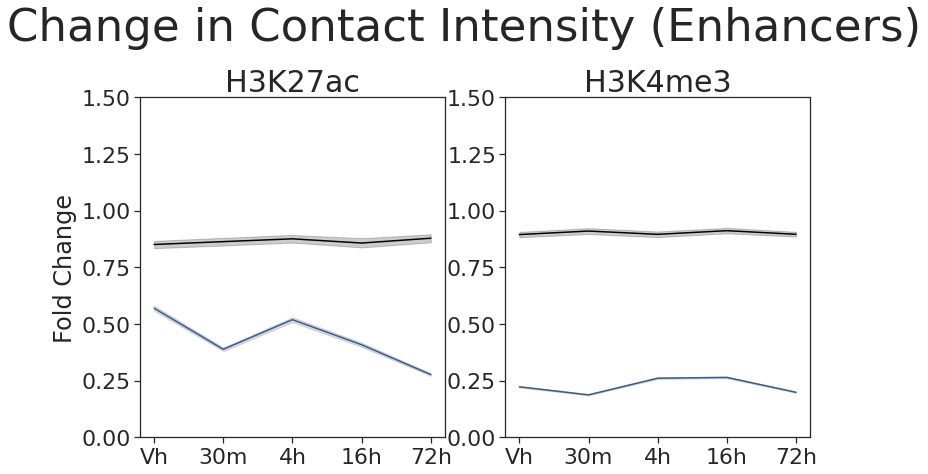

In [40]:

fig = plt.figure(figsize=[12,7])
gs = gridspec.GridSpec(nrows=1, ncols=2, top=0.8)

fig.add_subplot(gs[0])
tmp1 = pd.DataFrame(np.array(FC1_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
#sns.lineplot(data=tmp1, x='level_1',y=0, color='#D90000')
tmp2 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#3d5a80')
tmp3 = pd.DataFrame(np.array(FC3_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color='#000000')


plt.ylim(0, 1.5)


plt.title(f"H3K27ac", fontsize=30)


plt.ylabel("Fold Change")

#plt.plot(np.linspace(-1,5, 5), [1]*5, lw=2, ls='--', color='#888888')
#plt.xlim(-0.5,4.5)
plt.xlabel('')

fig.add_subplot(gs[1])
tmp1 = pd.DataFrame(np.array(FC1_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
#sns.lineplot(data=tmp1, x='level_1',y=0, color='#D90000')
tmp2 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#3d5a80')
tmp3 = pd.DataFrame(np.array(FC3_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color='#000000')


plt.ylim(0, 1.5)


plt.title(f"H3K4me3", fontsize=30)



fig.suptitle('Change in Contact Intensity (Enhancers)', fontsize=45)




#plt.plot(np.linspace(-1,5, 5), [1]*5, lw=2, ls='--', color='#888888')
#plt.xlim(-0.5,4.5)

plt.ylabel('')
plt.xlabel('')

fig.savefig('../plots/contactChangeEnhancer_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )

# Epigenome Changes

In [6]:
bed = pd.read_table('FOXA1/sets/11_ATAC.ALL_FOXA1.ALL.bed', names=['Chr', 'Start', 'End'])
bed['Name'] = bed['Chr'] +':'+ bed['Start'].astype(str) +'-'+ bed['End'].astype(str)
bed['Set'] = bed['Name'].map(MAPcl)

np.random.seed(7)
geneset = list(np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=100))


foxar = bed.loc[bed['Set'] == 'ARcre', 'Name'].tolist()
foxcre = bed.loc[bed['Set'] == 'cre', 'Name'].tolist()

l = list(set(flatten([list(H.neighbors(a)) for a in down if a in H.nodes])))
arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]
print( len(arcre_andr_kac_fox))

cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]
print( len(cre_andr_kac_fox))

l = list(set(flatten([list(H.neighbors(a)) for a in down  if a in H.nodes])))
cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in geneset  if a in H.nodes])))
cre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in geneset  if a in H.nodes])))
arcre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'ARcre']

35
67


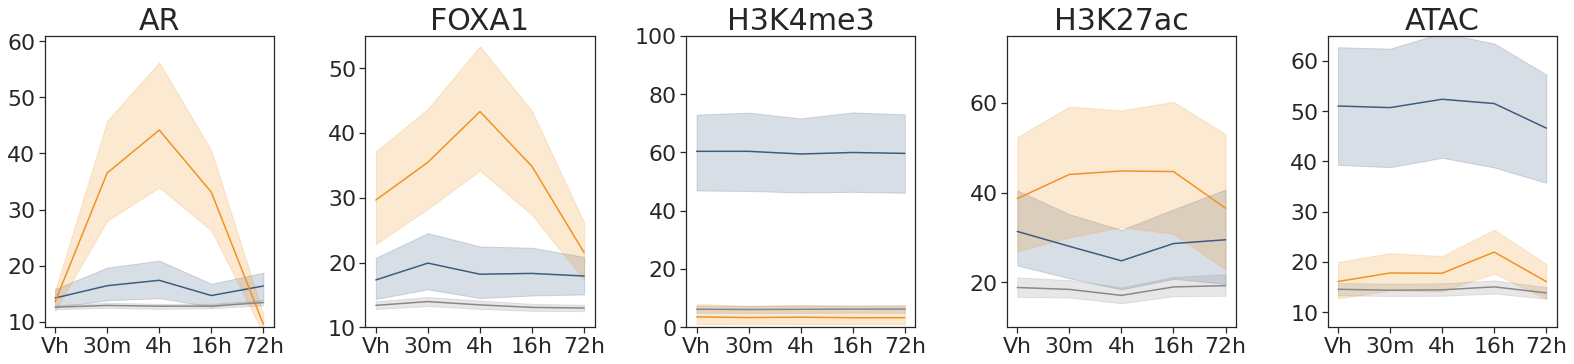

In [10]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,55), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,65)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(down)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#3d5a80')


    n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])


    n = N[N.index.isin(cre_high_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])

    
    
#fig.supylabel('TMM Normalized',fontsize=30)

#fig.savefig('../plots/down_epigenome_FINAL2.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [11]:
n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
n = n.stack().reset_index()
tmp = n['level_1'].str.split('_', expand=True)

n['Signal'] = tmp[0]
n['Time'] = tmp[1]


n

,Name,level_1,0,Signal,Time
0,chr1:37912245-37917245,ATAC_Vh,11.133726,ATAC,Vh
1,chr1:37912245-37917245,ATAC_30m,12.844797,ATAC,30m
2,chr1:37912245-37917245,ATAC_4h,15.756518,ATAC,4h
3,chr1:37912245-37917245,ATAC_16h,13.744605,ATAC,16h
4,chr1:37912245-37917245,ATAC_72h,8.266256,ATAC,72h
...,...,...,...,...,...
1045,chr8:26057408-26062408,FOXA1_Vh,89.128158,FOXA1,Vh
1046,chr8:26057408-26062408,FOXA1_30m,81.701660,FOXA1,30m
1047,chr8:26057408-26062408,FOXA1_4h,116.334789,FOXA1,4h
1048,chr8:26057408-26062408,FOXA1_16h,80.295242,FOXA1,16h


In [14]:
from scipy.stats import ranksums

tmp = n[n['Signal'] == 'ATAC']
ranksums(tmp.loc[tmp['Time'] == 'Vh',0], tmp.loc[tmp['Time'] == '16h',0])

RanksumsResult(statistic=-2.2728688345993264, pvalue=0.02303408538922926)

<AxesSubplot:>

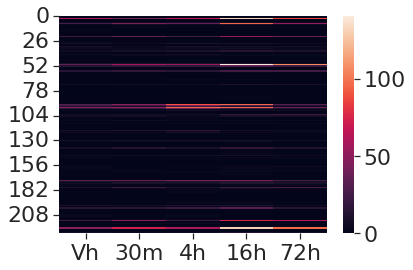

In [29]:
sns.heatmap(c1)

<AxesSubplot:>

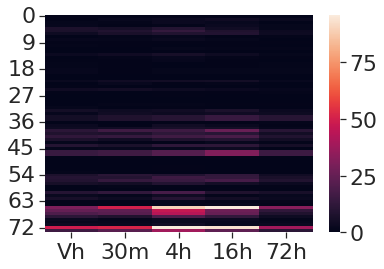

In [31]:
sns.heatmap(c1)

/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='level_1', ylabel='0'>

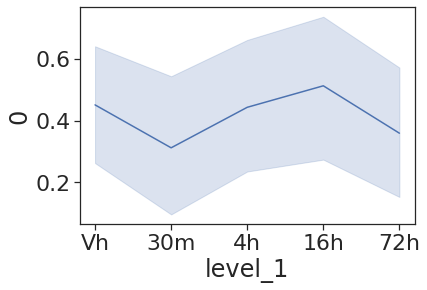

In [28]:
sns.lineplot(data=np.log(c1).stack().reset_index(), x='level_1', y=0)